# <font color='blue'>Formação Cientista de Dados
Projeto com Feedback 3
    </font>

## Eduardo Frigini de Jesus

## Prevendo o Nível de Satisfação dos Clientes do Santander

In [1]:
# Importando os módulos
import pandas as pd                 
import matplotlib.pyplot as plt    
import numpy as np         
import os
%matplotlib inline             

import os.path
import pickle
import seaborn as sns
import math
import gc

from sklearn import datasets, linear_model
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from scipy import stats

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Carregando o dataset
df_treino = pd.read_csv("train.csv")

## Observação:
### Os datasets teste e sample, se completam. Juntei os dois, mas o target esta todo como 0 entao nao vou utilizar esses dados para testes
### Decidi usar apenas o dataset de treino e separar o arquivo train.csv e dados de teste e treino

In [3]:
df_treino = df_treino.set_index('ID')

In [4]:
type(df_treino) 

pandas.core.frame.DataFrame

In [5]:
# Verificando o formato dos dados
df_treino.shape

(76020, 370)

In [6]:
# Verificando se existem valores nulos
df_treino.isnull().values.any()

False

# Verificando e Balanceando os dados

In [7]:
# Verificando como os dados estão distribuídos, no treino
num_true = len(df_treino.loc[df_treino['TARGET'] == True])
num_false = len(df_treino.loc[df_treino['TARGET'] == False])
print("Número de Casos Verdadeiros: {0} ({1:2.2f}%)".format(num_true, (num_true/ (num_true + num_false)) * 100))
print("Número de Casos Falsos     : {0} ({1:2.2f}%)".format(num_false, (num_false/ (num_true + num_false)) * 100))

Número de Casos Verdadeiros: 3008 (3.96%)
Número de Casos Falsos     : 73012 (96.04%)


In [8]:
# Balanceando os dados de treino
df_treino_true = (df_treino.loc[df_treino['TARGET']==True])
df_treino_false = (df_treino.loc[df_treino['TARGET']==False]).sample(3008)

# df = Data Frame Balanceado 50% 50%
df = pd.concat([df_treino_true, df_treino_false])
df.head(5)

,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,imp_op_var40_ult1,...,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38,TARGET
ID,,,,,,,,,,,,,,,,,,,,,
77,2,66,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,63324.90,1
159,2,45,0.0,26.97,184.47,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,124988.25,1
220,2,42,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,69591.48,1
303,2,31,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,45265.38,1
306,2,62,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,109595.55,1


In [9]:
# Verificando como os dados estão distribuídos
num_true = len(df.loc[df['TARGET'] == True])
num_false = len(df.loc[df['TARGET'] == False])
print("Número de Casos Verdadeiros: {0} ({1:2.2f}%)".format(num_true, (num_true/ (num_true + num_false)) * 100))
print("Número de Casos Falsos     : {0} ({1:2.2f}%)".format(num_false, (num_false/ (num_true + num_false)) * 100))

Número de Casos Verdadeiros: 3008 (50.00%)
Número de Casos Falsos     : 3008 (50.00%)


# Feature Selection

In [10]:
# Identificando a correlação entre as variáveis
# Correlação não implica causalidade
def plot_corr(df, size=10):
    corr = df.corr()    
    fig, ax = plt.subplots(figsize = (size, size))
    ax.matshow(corr)  
    plt.xticks(range(len(corr.columns)), corr.columns) 
    plt.yticks(range(len(corr.columns)), corr.columns)  

In [11]:
# Criando o gráfico 
#plot_corr(df)

In [12]:
# Visualizando a correlação em tabela
# Coeficiente de correlação: 
# +1  = forte correlação positiva
# 0   = não há correlação
# -1  = forte correlação negativa
#df.corr()

In [13]:
df.shape

(6016, 370)

In [14]:
# Como sao muitas variaveis (colunas) resolvi automatizar o processo de Feature Selection
# Decidi escolher as variaveis que mais correlacionam com o TARGET
# atraves do p-value <= 0.05 e correlation > 0.07

# Alterar o valor de correl(correlacao) para reduzir ou aumentar o nº de variaveis preditoras
correl = 0.07

# O valor normalmente utilizado para o pvalue é menor que 0.05
pvalue = 0.05

n=0
atributos = []
col_alvo = df.columns[369]
alvo = df[col_alvo].dropna()
n_col = df.shape[1]
print('Col','Correl', 'Pvalue')
for c in range(1, n_col):
    cx = df.columns[c]
    c2 = df[cx].dropna() 
    z_stat, p_val = stats.pearsonr(alvo,c2)
    t1 = (c, round(z_stat,3), round(p_val,3))
    
    if (t1[2] <= pvalue) and (t1[1] > correl):
        atributos.append(df.columns[c])
        n = n+1
        print(t1)
        
print("\n",atributos, "\n")
print("Total de variaveis preditoras selecionadas = ", n, "\n")

Col Correl Pvalue
(1, 0.242, 0.0)
(12, 0.084, 0.0)
(13, 0.08, 0.0)
(15, 0.084, 0.0)
(16, 0.08, 0.0)
(27, 0.079, 0.0)
(93, 0.079, 0.0)
(193, 0.264, 0.0)
(369, 1.0, 0.0)

 ['var15', 'imp_op_var41_efect_ult1', 'imp_op_var41_efect_ult3', 'imp_op_var39_efect_ult1', 'imp_op_var39_efect_ult3', 'ind_var8_0', 'num_var8_0', 'var36', 'TARGET'] 

Total de variaveis preditoras selecionadas =  9 



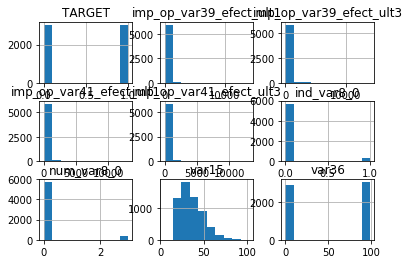

In [15]:
df2 = df[atributos]
df2.hist()
plt.show()

In [16]:
# Para evitar erros, quando aumentar o nº de variaveis preditoras,
# a dimensao (dim) da apresentacao dos graficos e calculada pelo n (numero de variaveis preditoras)
if n >= 6:
    dim = int(n / 2) - 1
else: 
    dim = 3
dim

3

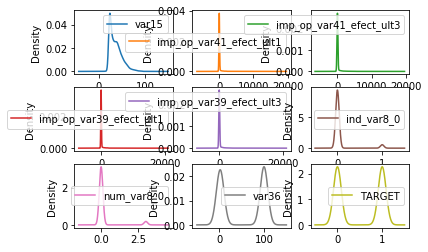

In [17]:
##### Density Plot Univariado
df2.plot(kind = 'density', subplots = True, layout = (dim,dim), sharex = False)
plt.show()

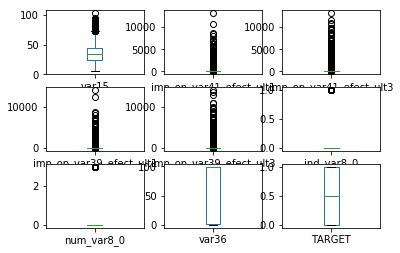

In [18]:
# Box and Whisker Plots
df2.plot(kind = 'box', subplots = True, layout = (dim,dim), sharex = False, sharey = False)
plt.show()

In [19]:
df2.corr()

,var15,imp_op_var41_efect_ult1,imp_op_var41_efect_ult3,imp_op_var39_efect_ult1,imp_op_var39_efect_ult3,ind_var8_0,num_var8_0,var36,TARGET
var15,1.000000,0.094715,0.108172,0.094344,0.107189,0.109712,0.109712,-0.031895,0.242170
imp_op_var41_efect_ult1,0.094715,1.000000,0.890599,0.996426,0.890775,0.314309,0.314309,-0.169474,0.083922
imp_op_var41_efect_ult3,0.108172,0.890599,1.000000,0.887749,0.997052,0.331225,0.331225,-0.187692,0.079902
imp_op_var39_efect_ult1,0.094344,0.996426,0.887749,1.000000,0.893801,0.314056,0.314056,-0.166708,0.083674
imp_op_var39_efect_ult3,0.107189,0.890775,0.997052,0.893801,1.000000,0.331088,0.331088,-0.185085,0.080036
ind_var8_0,0.109712,0.314309,0.331225,0.314056,0.331088,1.000000,1.000000,-0.110089,0.079012
num_var8_0,0.109712,0.314309,0.331225,0.314056,0.331088,1.000000,1.000000,-0.110089,0.079012
var36,-0.031895,-0.169474,-0.187692,-0.166708,-0.185085,-0.110089,-0.110089,1.000000,0.263934
TARGET,0.242170,0.083922,0.079902,0.083674,0.080036,0.079012,0.079012,0.263934,1.000000


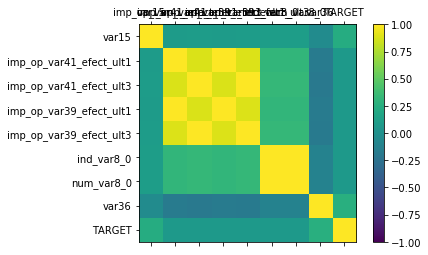

In [20]:
# Matriz de Correlação com nomes das variáveis
correlations = df2.corr()

# Plot
import numpy as np
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(correlations, vmin = -1, vmax = 1)
fig.colorbar(cax)
ticks = np.arange(0, 9, 1)
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.set_xticklabels(atributos)
ax.set_yticklabels(atributos)
plt.show()

## Algumas variaveis sao colineares

In [21]:
atributos

['var15',
 'imp_op_var41_efect_ult1',
 'imp_op_var41_efect_ult3',
 'imp_op_var39_efect_ult1',
 'imp_op_var39_efect_ult3',
 'ind_var8_0',
 'num_var8_0',
 'var36',
 'TARGET']

In [22]:
# Removendo variaveis colineares
atributos.remove('imp_op_var41_efect_ult3')

In [23]:
atributos.remove('imp_op_var39_efect_ult1')
atributos.remove('imp_op_var39_efect_ult3')

In [24]:
atributos.remove('num_var8_0')

In [25]:
df2 = df[atributos]

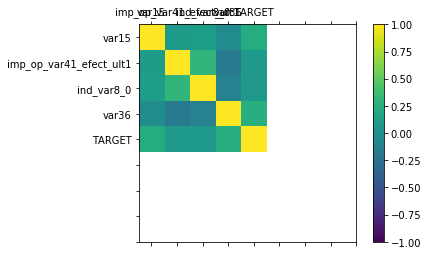

In [26]:
# Matriz de Correlação com nomes das variáveis
correlations = df2.corr()
# Plot
import numpy as np
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(correlations, vmin = -1, vmax = 1)
fig.colorbar(cax)
ticks = np.arange(0, 9, 1)
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.set_xticklabels(atributos)
ax.set_yticklabels(atributos)
plt.show()

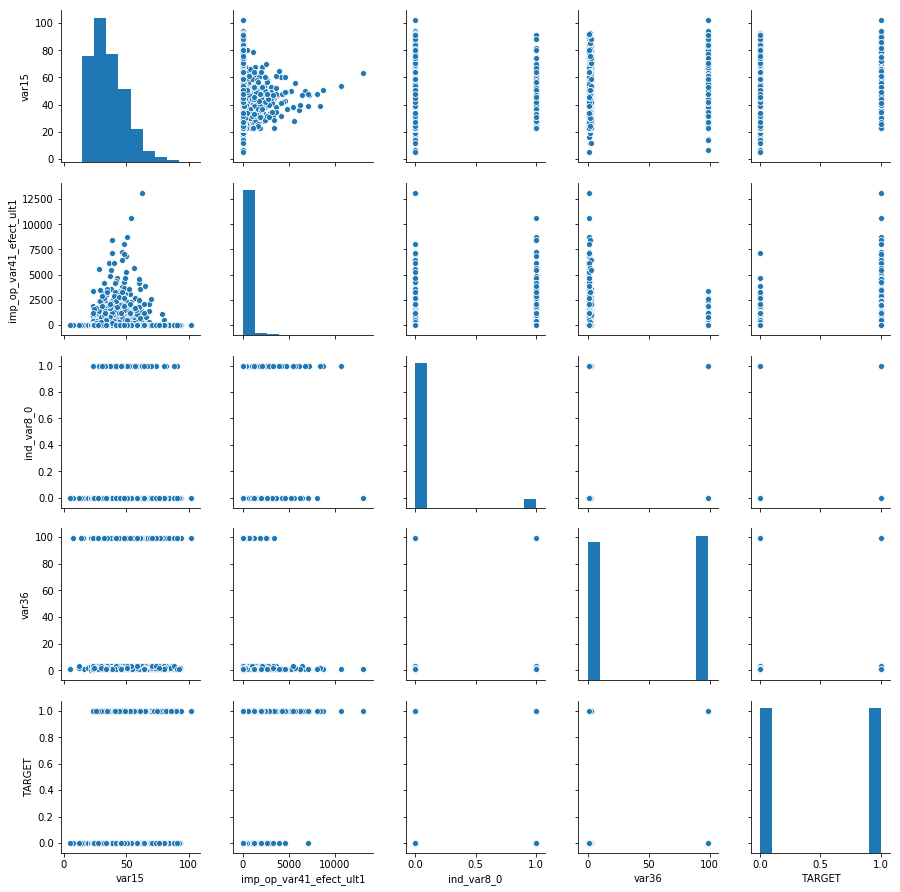

In [27]:
import seaborn as sns
# Pairplot
sns.pairplot(df2)

## Spliting

70% para dados de treino e 30% para dados de teste

In [28]:
from sklearn.model_selection import train_test_split

In [29]:
# Variável a ser prevista
atrib_prev = ['TARGET']
atributos.remove('TARGET')
atributos

['var15', 'imp_op_var41_efect_ult1', 'ind_var8_0', 'var36']

In [30]:
# Criando objetos
X = df[atributos].values
Y = df[atrib_prev].values

In [31]:
X

array([[6.6e+01, 0.0e+00, 0.0e+00, 9.9e+01],
       [4.5e+01, 0.0e+00, 0.0e+00, 1.0e+00],
       [4.2e+01, 0.0e+00, 0.0e+00, 1.0e+00],
       ...,
       [4.6e+01, 1.2e+03, 1.0e+00, 1.0e+00],
       [3.4e+01, 0.0e+00, 0.0e+00, 1.0e+00],
       [2.7e+01, 0.0e+00, 0.0e+00, 9.9e+01]])

In [32]:
Y

array([[1],
       [1],
       [1],
       ...,
       [0],
       [0],
       [0]], dtype=int64)

In [33]:
# Definindo a taxa de split
split_test_size = 0.30

In [34]:
# Criando dados de treino e de teste
X_treino, X_teste, Y_treino, Y_teste = train_test_split(X, Y, test_size = split_test_size, random_state = 42)

In [35]:
# Imprimindo os resultados
print("{0:0.2f}% nos dados de treino".format((len(X_treino)/len(df.index)) * 100))
print("{0:0.2f}% nos dados de teste".format((len(X_teste)/len(df.index)) * 100))

70.00% nos dados de treino
30.00% nos dados de teste


In [36]:
X_treino

array([[4.50e+01, 0.00e+00, 0.00e+00, 9.90e+01],
       [3.50e+01, 1.17e+03, 0.00e+00, 1.00e+00],
       [2.70e+01, 0.00e+00, 1.00e+00, 9.90e+01],
       ...,
       [2.40e+01, 0.00e+00, 0.00e+00, 9.90e+01],
       [3.40e+01, 0.00e+00, 0.00e+00, 1.00e+00],
       [4.50e+01, 0.00e+00, 0.00e+00, 9.90e+01]])

## Verificando o Split

In [37]:
print("Original True : {0} ({1:0.2f}%)".format(len(df.loc[df['TARGET'] == 1]), 
                                               (len(df.loc[df['TARGET'] ==1])/len(df.index) * 100)))

print("Original False : {0} ({1:0.2f}%)".format(len(df.loc[df['TARGET'] == 0]), 
                                               (len(df.loc[df['TARGET'] == 0])/len(df.index) * 100)))
print("")
print("Training True : {0} ({1:0.2f}%)".format(len(Y_treino[Y_treino[:] == 1]), 
                                               (len(Y_treino[Y_treino[:] == 1])/len(Y_treino) * 100)))

print("Training False : {0} ({1:0.2f}%)".format(len(Y_treino[Y_treino[:] == 0]), 
                                               (len(Y_treino[Y_treino[:] == 0])/len(Y_treino) * 100)))
print("")
print("Test True : {0} ({1:0.2f}%)".format(len(Y_teste[Y_teste[:] == 1]), 
                                               (len(Y_teste[Y_teste[:] == 1])/len(Y_teste) * 100)))

print("Test False : {0} ({1:0.2f}%)".format(len(Y_teste[Y_teste[:] == 0]), 
                                               (len(Y_teste[Y_teste[:] == 0])/len(Y_teste) * 100)))

Original True : 3008 (50.00%)
Original False : 3008 (50.00%)

Training True : 2073 (49.23%)
Training False : 2138 (50.77%)

Test True : 935 (51.80%)
Test False : 870 (48.20%)


## Valores Missing Ocultos



In [38]:
# Verificando se existem valores nulos
df.isnull().values.any()

False

## Construindo e treinando o modelo

In [39]:
# Utilizando um classificador Naive Bayes
from sklearn.naive_bayes import GaussianNB

In [40]:
# Criando o modelo preditivo
modelo_v1 = GaussianNB()

In [41]:
# Treinando o modelo
modelo_v1.fit(X_treino, Y_treino.ravel())

GaussianNB(priors=None, var_smoothing=1e-09)

## Verificando a exatidão no modelo nos dados de treino

In [42]:
from sklearn import metrics

In [43]:
nb_predict_train = modelo_v1.predict(X_treino)

In [44]:
print("Exatidão (Accuracy): {0:.4f}".format(metrics.accuracy_score(Y_treino, nb_predict_train)))
print()

Exatidão (Accuracy): 0.5555



## Verificando a exatidão no modelo nos dados de teste

In [45]:
nb_predict_test = modelo_v1.predict(X_teste)

In [46]:
print("Exatidão (Accuracy): {0:.4f}".format(metrics.accuracy_score(Y_teste, nb_predict_test)))
print()

Exatidão (Accuracy): 0.5269



## Métricas

In [47]:
# Criando uma Confusion Matrix
print("Confusion Matrix")

print("{0}".format(metrics.confusion_matrix(Y_teste, nb_predict_test, labels = [1, 0])))
print("")

print("Classification Report")
print(metrics.classification_report(Y_teste, nb_predict_test, labels = [1, 0]))

Confusion Matrix
[[155 780]
 [ 74 796]]

Classification Report
              precision    recall  f1-score   support

           1       0.68      0.17      0.27       935
           0       0.51      0.91      0.65       870

   micro avg       0.53      0.53      0.53      1805
   macro avg       0.59      0.54      0.46      1805
weighted avg       0.59      0.53      0.45      1805



# Gradient Boosting Classifier 

In [48]:
# Import do módulo
from sklearn.ensemble import GradientBoostingClassifier

In [49]:
# Criando o objeto Gradient Boosting 
modelo = GradientBoostingClassifier(n_estimators = 100, learning_rate = 1.0, max_depth = 1, random_state = 0)

In [50]:
# Treinando o modelo com dados de treino 
modelo.fit(X_treino, Y_treino)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=1.0, loss='deviance', max_depth=1,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              n_iter_no_change=None, presort='auto', random_state=0,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)

In [51]:
# Previsões
valores_previstos = modelo.predict(X_teste)
valores_previstos

array([1, 1, 0, ..., 0, 1, 1], dtype=int64)

In [52]:
# Verificando nos dados de teste
rf_predict_test = modelo.predict(X_teste)
print("Exatidão (Accuracy): {0:.4f}".format(metrics.accuracy_score(Y_teste, valores_previstos)))
print()

Exatidão (Accuracy): 0.7119



In [53]:
print("Confusion Matrix")

print("{0}".format(metrics.confusion_matrix(Y_teste, valores_previstos, labels = [1, 0])))
print("")

print("Classification Report")
print(metrics.classification_report(Y_teste, valores_previstos, labels = [1, 0]))

Confusion Matrix
[[622 313]
 [207 663]]

Classification Report
              precision    recall  f1-score   support

           1       0.75      0.67      0.71       935
           0       0.68      0.76      0.72       870

   micro avg       0.71      0.71      0.71      1805
   macro avg       0.71      0.71      0.71      1805
weighted avg       0.72      0.71      0.71      1805



# Otimizando o modelo com RandomForest

In [54]:
from sklearn.ensemble import RandomForestClassifier

In [55]:
modelo_v2 = RandomForestClassifier(random_state = 42)
modelo_v2.fit(X_treino, Y_treino.ravel())

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [56]:
# Verificando os dados de treino
rf_predict_train = modelo_v2.predict(X_treino)
print("Exatidão (Accuracy): {0:.4f}".format(metrics.accuracy_score(Y_treino, rf_predict_train)))

Exatidão (Accuracy): 0.7680


In [57]:
# Verificando nos dados de teste
rf_predict_test = modelo_v2.predict(X_teste)
print("Exatidão (Accuracy): {0:.4f}".format(metrics.accuracy_score(Y_teste, rf_predict_test)))
print()

Exatidão (Accuracy): 0.6970



In [58]:
print("Confusion Matrix")

print("{0}".format(metrics.confusion_matrix(Y_teste, rf_predict_test, labels = [1, 0])))
print("")

print("Classification Report")
print(metrics.classification_report(Y_teste, rf_predict_test, labels = [1, 0]))

Confusion Matrix
[[624 311]
 [236 634]]

Classification Report
              precision    recall  f1-score   support

           1       0.73      0.67      0.70       935
           0       0.67      0.73      0.70       870

   micro avg       0.70      0.70      0.70      1805
   macro avg       0.70      0.70      0.70      1805
weighted avg       0.70      0.70      0.70      1805



## Regressão Logística

In [59]:
from sklearn.linear_model import LogisticRegression

In [60]:
# Terceira versão do modelo usando Regressão Logística
modelo_v3 = LogisticRegression(C = 0.7, random_state = 42)
modelo_v3.fit(X_treino, Y_treino.ravel())
lr_predict_test = modelo_v3.predict(X_teste)

In [61]:
print("Exatidão (Accuracy): {0:.4f}".format(metrics.accuracy_score(Y_teste, lr_predict_test)))
print()
print("Classification Report")
print(metrics.classification_report(Y_teste, lr_predict_test, labels = [1, 0]))

Exatidão (Accuracy): 0.6936

Classification Report
              precision    recall  f1-score   support

           1       0.71      0.68      0.70       935
           0       0.67      0.70      0.69       870

   micro avg       0.69      0.69      0.69      1805
   macro avg       0.69      0.69      0.69      1805
weighted avg       0.69      0.69      0.69      1805



In [62]:
### Resumindo
## Exatidão nos dados de teste

# Modelo usando algoritmo Naive Bayes                 = 0.5269
# Modelo usando algoritmo GradientBoostingClassifier  = 0.7119 
# Modelo usando algoritmo Random Forest               = 0.6970
# Modelo usando algoritmo Regressão Logística         = 0.6936

## Fazendo Previsões Com o Modelo Treinado
## O Gradient Boosting Classifier foi o melhor modelo

In [63]:
import pickle

In [67]:
# Salvando o modelo para usar mais tarde
filename = 'modelo_treinado.sav'
pickle.dump(modelo, open(filename, 'wb'))

In [68]:
X_teste

array([[31.,  0.,  0., 99.],
       [38.,  0.,  0., 99.],
       [23.,  0.,  0.,  3.],
       ...,
       [26.,  0.,  0.,  3.],
       [28.,  0.,  0., 99.],
       [32.,  0.,  0., 99.]])

In [70]:
# Carregando o modelo e fazendo previsão com novos conjuntos de dados 
# (X_teste, Y_teste devem ser novos conjuntos de dados preparados com o procedimento de limpeza e transformação adequados)
loaded_model = pickle.load(open(filename, 'rb'))
resultado1 = loaded_model.predict(X_teste[20].reshape(1, -1))
resultado2 = loaded_model.predict(X_teste[50].reshape(1, -1))
print(resultado1)
print(resultado2)

[1]
[0]


# Fim